<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 8. Стохастический градиентный спуск, онлайн-обучение, Vowpal Wabbit</center>

Всем привет! Вот мы постепенно и дошли до продвинутых методов машинного обучения, сегодня обсудим, как вообще подступиться к обучению модели, если данных гигабайты и десятки гигабайт.
Обсудим приемы, позволяющие это делать: стохастический градиентный спуск (SGD) и хэширование признаков, посмотрим на примеры применения библиотеки Vowpal Wabbit. Домашнее задание будет как на реализацию SGD-алгоритмов, так и на обучение классификатора вопросов на StackOverflow по выборке в 10 Гб. 

Поехали!

# План
- Стохастический градиентный спуск и онлайн-подход к обучению
    - Стохастический градиентный спуск
    - Онлайн-подход к обучению
- Работа с категориальными признаками: Label Encoding, One-Hot Encoding, Hashing trick
    - Label Encoding
    - One-Hot Encoding
    - Хэширование признаков (Hashing trick)
- Vowpal Wabbit
    - Новости. Бинарная классификация
    - Письма. Многоклассовая классификация
    - Рецензии к фильмам IMDB
    - Классификация вопросов на Stackoverflow 

Вначале импортируем сразу все нужные библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import fetch_20newsgroups, load_files

import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Стохастический градиентный спуск и онлайн-подход к обучению
## Стохастический градиентный спуск

Несмотря на то, что градиентный спуск – одна из первых тем, изучаемых в теории оптимизации и машинном обучении, сложно переоценить важность одной его модификации – стохастического градиентного спуска, который мы часто будем называть просто SGD (Stochastic Gradient Descent). 

Напомним, что суть градиентного спуска – минимизировать функцию, делая небольшие шаги в сторону наискорейшего убывания функции. Название методу подарил тот факт из математического анализа, что вектор $\nabla f = (\frac{\partial f}{\partial x_1}, \ldots \frac{\partial f}{\partial x_n})^T$ частных производных функции $f(x) = f(x_1, \ldots x_n)$ задает направление наискорейшего возрастания этой функции. Значит, двигаясь в сторону антиградиента функции (вектора, противоположного градиенту), можно уменьшать ее значение быстрее всего. 

<img src='../../img/snowboard.jpg' width=70%>

Это я в Шерегеше – всем катающим советую хотя бы раз в жизни там оказаться. Картинка для успокоения глаз, но с ее помощью можно пояснить интуицию градиентного спуска. Если задача – как можно быстрее спуститься с горы на сноуборде, то нужно в каждой точке выбирать максимальный уклон (если это совместимо с жизнью). Вычисление антиградиента – это и есть оценка крутизны склона в данной точке. 

**Пример**

Задачу простой парной регрессии можно решать с помощью градиентного спуска. Предположим, мы прогнозируем одну переменную по другой – рост по весу – и постулируем линейную зависимость роста от веса.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
data_demo = pd.read_csv('../../data/weights_heights.csv')

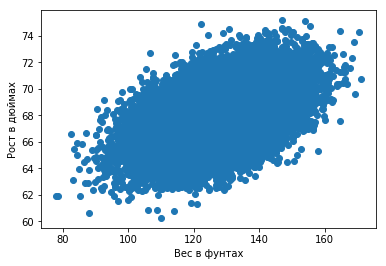

In [3]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес в фунтах')
plt.ylabel('Рост в дюймах');

Даны вектор $x$ длины $\ell$– значения веса для каждого наблюдения (человека) и $y$ – вектор значений роста для каждого наблюдения (человека).

Задача: найти такие веса $w_0$ и $w_1$, чтобы при прогнозе роста по весу в виде $y_i = w_0 + w_1 x_i$ (где $y_i$ – $i$-ое значение роста, $x_i$ –  $i$-ое значение веса) минимизировать квадратичную ошибку (можно и среднеквадратичную, но константа $\frac{1}{\ell}$ погоды не делает, а $\frac{1}{2}$ заведена для красоты):
$$SE(w_0, w_1) = \frac{1}{2}\sum_{i=1}^\ell(y_i - (w_0 + w_1x_{i}))^2 \rightarrow min_{w_0,w_1}$$

Делать мы это будем с помощью градиентного спуска, посчитав частные производные функции $SE(w_0, w_1)$ по весам в модели – $w_0$ и $w_1$.
Итеративная процедура обучения будет задаваться простыми формулами обновления весов (меняем веса так, чтобы длать небольшой, пропорционально малой константе $\eta$, шаг в сторону антиградиента функции):

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} -\eta \frac{\partial SE}{\partial w_0} |_{t} \\  w_1^{(t+1)} = w_1^{(t)} -\eta \frac{\partial SE}{\partial w_1} |_{t} \end{array}$$

Если обратиться к ручке и бумажке и найти аналитические выражения для частных производных, то получим 

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} + \eta \sum_{i=1}^{\ell}(y_i - w_0^{(t)} - w_1^{(t)}x_i) \\  w_1^{(t+1)} = w_1^{(t)} + \eta \sum_{i=1}^{\ell}(y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i \end{array}$$

И все это довольно хорошо работает (в этой статье мы не будем обсуждать проблемы локальных минимумов, подбора шага градиентного спуска, момент и т.д. – про это и так много написано, можно обратиться к [главе](http://www.deeplearningbook.org/contents/numerical.html) "Numeric Computation" книги "Deep Learning") пока данных не становится слишком много. Проблема такого подхода в том, что вычисление градиента сводится к суммированию некоторых величин для каждого объекта обучающей выборки. То есть попросту, проблема в том, что итераций алгоритму на практике требуется много, а на каждой итерации веса пересчитываются по формуле, в которой есть сумма по всей выборке вида $\sum_{i=1}^\ell$. А что если объектов в выборке миллионы и миллиарды?



Суть стохастического градиентного спуска – неформально, выкинуть знак суммы из формул пересчета весов и обновлять их по одному объекту. То есть в нашем случае

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i) \\  w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i \end{array}$$

При таком подходе на каждой итерации уже совсем не гарантировано движение в сторону наискорейшего убывания функции, и итераций может понадобиться на пару порядков больше, чем при обычном градиентном спуске. Зато пересчет весов на каждой итерации делается почти мгновенно. 

В качестве иллюстрации возьмем картинку Эндрю Ына из его [курса](https://www.coursera.org/learn/machine-learning) машинного обучения.

<img src='../../img/sgd_convergence.png'>

Нарисованы линии уровня некоторой функции, минимум который мы ищем. Красная кривая изображает изменение весов (на картинке $\theta_0$ и $\theta_1$ соответсвуют $w_0$ и $w_1$ в нашем примере). По свойствам градиента направление изменения в каждой точке будет перпендикулярно линиям уровня. При стохастическом подходе на каждой итерации веса меняется менее предсказуемо, порой даже кажется, что некоторые шаги неудачны – уводят от заветного минимума, но в итоге обе процедуры сходятся примерно к одному решению.

Сходимость стохатического градиентного спуска к тому же решению, что и у градиентного спуска, является одним из важнейших фактов, доказанных в теории оптимизации. Сейчас в эпоху Deep Data и Big Learning чаще даже градиентным спуском называет именно его стохастическую версию.

## Онлайн-подход к обучению
Стохастический градиентный спуск, будучи одним из методов оптимизации, дает вполне практическое руководство к обучению алгоритмов классификации и регрессии на больших выборках – до сотен гигабайт (в зависимости от имеющейся памяти).

В случае парной регрессии, который мы рассмотрели, на диске можно хранить обучающую выборку $(X,y)$ и, не загружая ее в оперативную память (она может попросту не поместиться), считывать объекты по одному и обновлять веса:

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i) \\  w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i \end{array}$$

После обработки всех объектов обучающей выборки, функционал, который мы оптимизируем (квадратичная ошибка в задаче регрессии или, напрмиер, логистическая – в задаче классификации) снизится, но часто нужно несколько десятков проходов по выборке, чтобы он снизился достаточно. 

Такой подход к обучению моделей часто называют онлайн-обучением, термин появился еще до того, как MOOC-и стали мэйнстримом.

<img src="../../img/andrew_ng_online_learning.jpg" width=50%>

В этой статье мы не рассматриваем многих нюансов стохастической оптимизации (вот хорошая [статья](https://habrahabr.ru/post/318970/) на Хабре, фундаментально изучить эту тему можно по книге Boyd "Convex Optimization"), перейдем скорее к библиотеке Vowpal Wabbit, с помощью которой можно обучать простые модели на огромных выборках за счет стохастической оптимизации и еще одного трюка – хэширования признаков, о котором пойдет речь далее.

В библиотеке Scikit-learn классификаторы и регрессоры, обучаемые стохастическим градиентным спуском, реализованы классами `SGDClassifier` и `SGDRegressor` из `sklearn.linear_model`. Частью домашнего задания будет разобраться в них уже после собственной реализации этих простых онлайн-алгоритмов.

# Работа с категориальными признаками: Label Encoding, One-Hot Encoding, Hashing trick

## Label Encoding
Подавляющее большинство методов классификации и регрессии сформулированы в терминах евклидовых или метрических пространств, то есть подразумевают представление данных в виде вещественных векторов одинаковой размерности. В реальных данных, однако, не так редки категориальные признаки, принимающие дискретные значения, такие как да/нет или  январь/февраль/.../декабрь. Обсудим то, как работать с такими данными, в частности с помощью линейных моделей, и что делать, если категориальных признаков много, да еще и у каждого куча уникальных значений. 

Рассмотрим выборку UCI bank, в которой большая часть признаков – категориальные.

In [4]:
df = pd.read_csv('../../data/bank_train.csv')
labels = pd.read_csv('../../data/bank_train_target.csv', header=None)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Нетрудно заметить, что достаточно много признаков в этом наборе данных не представлены числами. В таком виде данные еще нам не подходят - мы не сможем применять подавляющее большинство доступных нам методов.

Чтобы найти решение, давайте рассмотрим признак education:

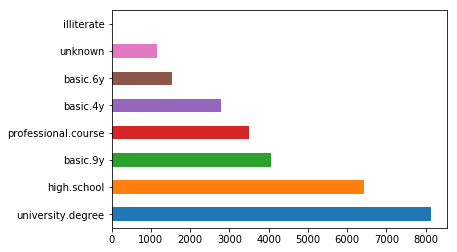

In [5]:
df['education'].value_counts().plot.barh();

Естественным решением такой проблемы было бы однозначное отображение каждого значения в уникальное число. К примеру, мы могли бы преобразовать `university.degree` в 0, а `basic.9y` в 1. Эту простую операцию приходится делать часто, поэтому в модуле `preprocessing` библиотеки `sklearn` именно для этой задачи реализован класс `LabelEncoder`:

In [6]:
label_encoder = LabelEncoder()

Метод `fit` этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод `transform` непосредственно преобразует значения в числа. После `fit` у `label_encoder` будет доступно поле `classes_`, содержащее все уникальные значения. Пронумеруем их, чтобы убедиться, что преобразование выполнено верно. 

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


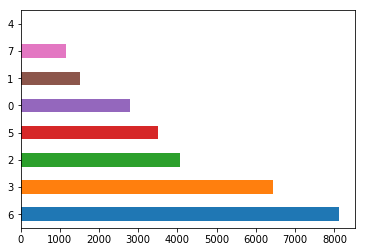

In [7]:
mapped_education = pd.Series(label_encoder.fit_transform(df['education']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

Что произойдет, если у нас появятся данные с другими категориями?

In [8]:
try:
    label_encoder.transform(df['education'].replace('high.school', 'high_school'))
except Exception as e:
    print('Error:', e)

Error: y contains new labels: ['high_school']


Таким образом, при использовании этого подхода мы всегда должны быть уверены, что признак не может принимать неизвестных ранее значений. К этой проблеме мы вернемся чуть позже, а сейчас заменим весь столбец education на преобразованный:

In [9]:
df['education'] = mapped_education
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,3,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,6,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,0,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,6,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,6,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Продолжим преобразование для всех столбцов, имеющих тип `object` – именно этот тип задается в pandas для таких данных.

In [10]:
categorical_columns = df.columns[df.dtypes == 'object'].union(['education'])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


Основная проблема такого представления заключается в том, что числовой код создал евклидово представление для данных.

К примеру, нами неявным образом была введена алгебра над значениями работы - мы можем вычесть работу клиента 1 из работы клиента 2:

In [11]:
df.loc[1].job - df.loc[2].job

-1.0

Конечно же, эта операция не имеет никакого смысла. Но именно на этом основаны метрики близости объектов, что делает бессмысленным применение метода ближайшего соседа на данных в таком виде. Аналогичным образом, никакого смысла не будет иметь применение линейных моделей. Убедимся в этом:

In [12]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe.as_matrix()
    train_features, test_features, train_labels, test_labels = \
        train_test_split(features, labels)

    logit = LogisticRegression()
    logit.fit(train_features, train_labels)
    return classification_report(test_labels, logit.predict(test_features))

print(logistic_regression_accuracy_on(df[categorical_columns], labels))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94      6157
          1       1.00      0.00      0.00       742

avg / total       0.90      0.89      0.84      6899



Для того, чтобы мы смогли применять линейные модели на таких данных нам необходим другой метод, который называется One-Hot Encoding

## One-Hot Encoding

Предположим, что некоторый признак может принимать 10 разных значений. В этом случае one hot encoding подразумевает создание 10 признаков, все из которых равны нулю *за исключением одного*. На позицию, соответствующую численному значению признака мы помещаем 1:

In [13]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


Эта техника реализована в `sklearn.preprocessing` в классе `OneHotEncoder`. По умолчанию `OneHotEncoder` преобразует данные в разреженную матрицу, чтобы не расходовать память на хранение многочисленных нулей. Однако в этом примере размер данных не является для нас проблемой, поэтому мы будем использовать "плотное" представление.

In [14]:
onehot_encoder = OneHotEncoder(sparse=False)

In [15]:
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Мы получили 53 столбца - именно столько различных уникальных значений могут принимать категориальные столбцы исходной выборки. Преобразованные с помощью One-Hot Encoding данные начинают обретать смысл для линейной модели:

In [16]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

             precision    recall  f1-score   support

          0       0.90      0.99      0.94      6106
          1       0.70      0.17      0.27       793

avg / total       0.88      0.90      0.87      6899



## Хэширование признаков (Hashing trick)
Реальные данные могут оказаться гораздо более динамичными, и мы не всегда можем рассчитывать, что категориальные признаки не будут принимать новых значений. Все это сильно затрудняет использование уже обученных моделей на новых данных. Кроме того, `LabelEncoder` подразумевает предварительный анализ всей выборки и хранение построенных отображений в памяти, что затрудняет работу в режиме больших данных.

Для решения этих проблем существует более простой подход к векторизации категориальных признаков, основанный на хэшировании, известный как hashing trick. 

Хэш-функции могут помочь нам в задаче поиска уникальных кодов для различных значений признака, к примеру:

In [17]:
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s))

university.degree -> -663893756866935401
high.school -> -6292925882924186606
illiterate -> 3821546169608474728


Отрицательные и настолько большие по модулю значения нам не подойдут. Ограничим область значений хэш-функции:

In [18]:
hash_space = 25
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s) % hash_space)

university.degree -> 24
high.school -> 19
illiterate -> 3


Представим, что у нас в выборке есть холостой студент, которому позвонили в понедельник, тогда его вектор признаков будет сформирован аналогично One-Hot Encoding, но в едином пространстве фиксированного размера для всех признаков:

In [19]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ('job=student', 'marital=single', 'day_of_week=mon'):
    print(s, '->', hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student -> 10
marital=single -> 21
day_of_week=mon -> 4


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Стоит обратить внимание, что в этом примере хэшировались не только значения признаков, а пары **название признака + значение признака**. Это необходимо, чтобы разделить одинаковые значения разных признаков между собой, к примеру:

In [20]:
assert hash('no') == hash('no')
assert hash('housing=no') != hash('loan=no')

Может ли произойти коллизия хэш-функции, то есть совпадение кодов для двух разных значений? Нетрудно доказать, что при достаточном размере пространства хэширования это происходит редко, но даже в тех случаях, когда это происходит, это не будет приводить к существенному ухудшению качества классификации или регрессии.

Возможно, вы спросите: "а что за хрень вообще происходит?", и покажется, что при хэшировании признаков страдает здравый смысл. Возможно, но эта эвристика – по сути, единственный подход к тому, чтобы работать с категориальными признаками, у которых много уникальных значений. Более того, эта техника себя хорошо зарекомендовала по результатами на практике. Подробней про хэширование признаков (learning to hash) можно почитать в [этом](https://arxiv.org/abs/1509.05472) обзоре, а также в [материалах](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture06-linclass.pdf) Евгения Соколова.

# Библиотека Vowpal Wabbit

Vowpal Wabbit (VW) является одной из наиболее широко используемых библиотек в индустрии. Её отличает высокая скорость работы и поддержка большого количества различных режимов обучения. Особый интерес для больших и высокоразмерных данных представляет онлайн-обучение  – самая сильная сторона библиотеки. 
Также реализовано хэширование признаков, и Vowpal Wabbit отлично подходит для работы с текстовыми данными.

Основным интерфейсом для работы с VW является shell.

In [21]:
!vw --help



VW options:
  --random_seed arg                     seed random number generator
  --ring_size arg                       size of example ring

Update options:
  -l [ --learning_rate ] arg            Set learning rate
  --power_t arg                         t power value
  --decay_learning_rate arg             Set Decay factor for learning_rate 
                                        between passes
  --initial_t arg                       initial t value
  --feature_mask arg                    Use existing regressor to determine 
                                        which parameters may be updated.  If no
                                        initial_regressor given, also used for 
                                        initial weights.

Weight options:
  -i [ --initial_regressor ] arg        Initial regressor(s)
  --initial_weight arg                  Set all weights to an initial value of 
                                        arg.
  --random_weights arg                  mak

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1


Vowpal Wabbit считывает данные из файла или стандартного ввода (stdin) в формате, который имеет следующий вид:

`[Label] [Importance] [Tag]|Namespace Features |Namespace Features ... |Namespace Features`

`Namespace=String[:Value]`

`Features=(String[:Value] )*`

где [] обозначает необязательные элементы, а (...)\* означает повтор неопределенное число раз. 

- **Label** является числом, "правильным" ответом. В случае классификации обычно принимает значение 1/-1, а в случае регрессии некоторое вещественное число
- **Importance** является числом и отвечает за вес примера при обучении. Это позволяет бороться с проблемой несбалансированных данных, изученной нами ранее
- **Tag** является некоторой строкой без пробелов и отвечает за некоторое "название" примера, которое сохраняется при предсказании ответа. Для того, чтобы отделить Tag от Importance лучше начинать Tag с символа '.
- **Namespace** служит для создания отдельных пространств признаков. В аргументах Namespace именуются по первой букве, это нужно учитывать при выборе их названий
- **Features** являются непосредственно признаками объекта внутри **Namespace**. Признаки по умолчанию имеют вес 1.0, но его можно переопределить, к примеру feature:0.1. 


К примеру, под такой формат подходит следующая строка:

```
1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park
```


чтобы убедиться в этом, запустим vw с этим обучающим примером:

In [23]:
!echo "1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park" | vw

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0   0.0000   0.0000       10

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1.000000
weighted label sum = 0.000000
average loss = 0.000000
total feature number = 10


VW является прекрасным инструментом для работы с текстовыми данными. Убедимся в этом с помощью выборки 20newsgroups, содержащей письма из 20 различных тематических рассылок.


## Новости. Бинарная классификация

In [25]:
newsgroups = fetch_20newsgroups('../../data/news_data')

In [26]:
newsgroups['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Рассмотрим первый текстовый документ этой коллекции:

In [27]:
text = newsgroups['data'][0]
target = newsgroups['target_names'][newsgroups['target'][0]]

print('-----')
print(target)
print('-----')
print(text.strip())
print('----')

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


Приведем данные к формату Vowpal Wabbit, при этом оставляя только слова не короче 3 символов. Здесь мы не выполняем многие важные в анализе текстов процедуры (стемминг и лемматизацию), но, как увидим, задача и так будет решаться хорошо.

In [28]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

to_vw_format(text, 1 if target == 'rec.autos' else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

Разобьем выборку на обучающую и тестовую и запишем в файл преобразованные таким образом документы. Будем считать документ положительным, если он относится к рассылке про автомобили **rec.autos**. Так мы построим модель, отличающую письма про автомобили от остальных: 

In [29]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos' 
               else -1 for target in newsgroups['target']]

In [34]:

import io
train_documents, test_documents, train_labels, test_labels = \
    train_test_split(all_documents, all_targets, random_state=7)
    
with io.open('../../data/news_data/20news_train.vw',  'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with io.open('../../data/news_data/20news_test.vw', 'w', encoding='utf-8') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Запустим Vowpal Wabbit на сформированном файле. Мы решаем задачу классификации, поэтому зададим функцию потерь в значение hinge (линейный SVM). Построенную модель мы сохраним в соответствующий файл `20news_model.vw`:

In [35]:
!vw -d ../../data/news_data/20news_train.vw \
  --loss_function hinge -f ../../data/news_data/20news_model.vw

final_regressor = ../../data/news_data/20news_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data/news_data/20news_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000      157
0.911276 0.822551            2            2.0  -1.0000  -0.1774      159
0.605793 0.300311            4            4.0  -1.0000  -0.3994       92
0.419594 0.233394            8            8.0  -1.0000  -0.8167      129
0.313998 0.208402           16           16.0  -1.0000  -0.6509      108
0.196014 0.078029           32           32.0  -1.0000  -1.0000      115
0.183158 0.170302           64           64.0  -1.0000  -0.7072      114
0.261046 0.338935          128          128.0   1.0000  -0.7900      110
0.262910 0.264774          256          256.0  -1.0000  -0.

Модель обучена. VW выводит достаточно много полезной информации по ходу обучения (тем не менее, ее можно погасить, если задать параметр --quiet). Подробно вывод диагностическйой информации разобран в документации VW на GitHub – [тут](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial#vws-diagnostic-information). Обратите внимание, что average loss снижался по ходу выполнения итераций. Для вычисления функции потерь VW использует еще не просмотренные примеры, поэтому, как правило, эта оценка является корректной. Применим обученную модель на тестовой выборке, сохраняя предсказания в файл с помощью опции -p: 

In [36]:
!vw -i ../../data/news_data/20news_model.vw -t -d ../../data/news_data/20news_test.vw \
-p ../../data/news_data/20news_test_predictions.txt

only testing
predictions = ../../data/news_data/20news_test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data/news_data/20news_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   1.0000      349
    n.a.     n.a.            2            2.0  unknown  -1.0000       50
    n.a.     n.a.            4            4.0  unknown  -1.0000      251
    n.a.     n.a.            8            8.0  unknown  -1.0000      237
    n.a.     n.a.           16           16.0  unknown  -0.8978      106
    n.a.     n.a.           32           32.0  unknown  -1.0000      964
    n.a.     n.a.           64           64.0  unknown  -1.0000      261
    n.a.     n.a.          128          128.0  unknown   0.4621       82
    n.a.     n.a.          256         

Загрузим полученные предсказания, вычислим AUC и отобразим ROC-кривую:

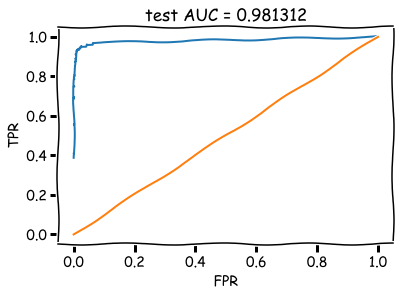

In [37]:
with io.open('../../data/news_data/20news_test_predictions.txt', encoding='utf-8') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
roc_curve = roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

Полученное значения AUC говорит о высоком качестве классификации.

# Новости. Многоклассовая классификация

Используем ту же выборку, что в прошлой части, но решаем задачу многоклассовой классификации. Тут `Vowpal Wabbit` слегка капризничает – он любит, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 20). Поэтому придется применить LabelEncoder, да еще и +1 потом добавить (`LabelEncoder` переводит метки в диапозон от 0 до K-1).

In [38]:
all_documents = newsgroups['data']
topic_encoder = LabelEncoder()
all_targets_mult = topic_encoder.fit_transform(newsgroups['target']) + 1

**Выборки будут те же, а метки поменяются, train_labels_mult и test_labels_mult – векторы меток от 1 до 20.**

In [39]:
train_documents, test_documents, train_labels_mult, test_labels_mult = \
    train_test_split(all_documents, all_targets_mult, random_state=7)

In [40]:
with io.open('../../data/news_data/20news_train_mult.vw', 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(train_documents, train_labels_mult):
        vw_train_data.write(to_vw_format(text, target))
with io.open('../../data/news_data/20news_test_mult.vw', 'w', encoding='utf-8') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Обучим Vowpal Wabbit в режиме многоклассовой классификации, передав параметр `oaa` (от "one against all"), равный числу классов. Также перечислим параметры, которые можно понастраивать, и от которых качество модели может довольно значительно зависеть (более полно – в официальном [тьюториале](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial) по Vowpal Wabbit):
 - темп обучения (-l, по умолчанию 0.5) – коэффициент перед изменением весов модели при каждом изменении
 - степень убывания темпа обучения (--power_t, по умолчанию 0.5) – на практике проверено, что если темп обучения уменьшается при увеличении числа итераций стохастического градиентного спуска, то минимум функции находится лучше 
 - функция потерь (--loss_function) – от нее, по сути, зависит обучаемый алгоритм. Про функции потерь в [документации](https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions)
 - регуляризация (-l1) – тут надо обратить внимание на то, что в VW регуляризация считается для каждого объекта, поэтому коэффициенты регуляризации обычно берутся малыми, около $10^{-20}.$
 
 Дополнительно можно попробовать автоматическую настройку параметров Vowpal Wabbit с Hyperopt. Пока это работает только с Python 2. [Статья](https://habrahabr.ru/company/dca/blog/272697/) на Хабре.

In [41]:
%%time
!vw --oaa 20 ../../data/news_data/20news_train_mult.vw \
-f ../../data/news_data/20news_model_mult.vw --loss_function=hinge

Wall time: 1.86 s


final_regressor = ../../data/news_data/20news_model_mult.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data/news_data/20news_train_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       15        1      157
1.000000 1.000000            2            2.0        2       15      159
1.000000 1.000000            4            4.0       15       10       92
1.000000 1.000000            8            8.0       16       15      129
1.000000 1.000000           16           16.0       13       12      108
0.937500 0.875000           32           32.0        2        9      115
0.906250 0.875000           64           64.0       16       16      114
0.867188 0.828125          128          128.0        8        4      110
0.816406 0.765625          256          256.0    

In [42]:
%%time
!vw -i ../../data/news_data/20news_model_mult.vw -t \
-d ../../data/news_data/20news_test_mult.vw \
-p ../../data/news_data/20news_test_predictions_mult.txt

Wall time: 320 ms


only testing
predictions = ../../data/news_data/20news_test_predictions_mult.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data/news_data/20news_test_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown        8      349
    n.a.     n.a.            2            2.0  unknown        6       50
    n.a.     n.a.            4            4.0  unknown       18      251
    n.a.     n.a.            8            8.0  unknown       18      237
    n.a.     n.a.           16           16.0  unknown        4      106
    n.a.     n.a.           32           32.0  unknown       15      964
    n.a.     n.a.           64           64.0  unknown        4      261
    n.a.     n.a.          128          128.0  unknown        8       82
    n.a.     n.a.          25

In [43]:
with io.open('../../data/news_data/20news_test_predictions_mult.txt', encoding='utf-8') as pred_file:
    test_prediction_mult = [float(label) 
                            for label in pred_file.readlines()]

In [44]:
accuracy_score(test_labels_mult, test_prediction_mult)

0.8734535171438671

В качестве примера анализа резльтатов, посмотрим, с какими темами классификатор путает атеизм.

In [45]:
M = confusion_matrix(test_labels_mult, test_prediction_mult)
M

array([[109,   0,   0,   0,   0,   0,   0,   1,   0,   1,   0,   0,   0,
          1,   0,   3,   0,   0,   0,   5],
       [  1, 123,   6,   2,   2,   3,   4,   2,   0,   1,   0,   0,   1,
          1,   0,   2,   0,   0,   0,   0],
       [  4,   2, 125,   3,   6,   2,   3,   0,   1,   0,   0,   0,   4,
          1,   0,   1,   0,   0,   0,   0],
       [  4,   4,   8,  92,   4,   2,   7,   2,   4,   0,   0,   1,   2,
          0,   1,   0,   0,   0,   1,   0],
       [  0,   4,   3,   8, 114,   3,   9,   0,   2,   1,   0,   0,   1,
          2,   1,   0,   0,   0,   0,   0],
       [  0,   9,   2,   3,   3, 119,   1,   1,   1,   0,   0,   1,   2,
          0,   1,   0,   0,   0,   0,   0],
       [  1,   1,   1,   4,   0,   1, 120,   4,   0,   0,   0,   0,   3,
          0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0,   1,   2,   1,   3, 114,   2,   2,   0,   0,   2,
          0,   1,   0,   0,   0,   0,   1],
       [  1,   0,   0,   1,   1,   0,   5,   4, 145,   0,   0,  

In [46]:
for i in np.where(M[0,:] > 0)[0][1:]:
    print(newsgroups['target_names'][i], M[0,i], )

rec.autos 1
rec.sport.baseball 1
sci.med 1
soc.religion.christian 3
talk.religion.misc 5


# Рецензии к фильмам IMDB

В этой части мы будем заниматься бинарной классификацией отзывов к фильмам, публикованным на сайте IMDB. Обратите внимание, насколько быстро будет работать Vowpal Wabbit.

Используем функцию `load_files` из `sklearn.datasets` для загрузки отзывов по фильмам [отсюда](https://drive.google.com/file/d/1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l/view?usp=sharing). Скачайте данные и укажите свой путь к каталогу `imdb_reviews` (в нем должны быть каталоги *train* и *test*). Разархивирование может занять несколько минут – там 100 тыс. файлов. В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам. Отделим данные (собственно, тексты) от меток.

In [47]:
# поменяйте на свой путь
path_to_movies = '../../../data/imdb_reviews/imdb_reviews/'
reviews_train = load_files(os.path.join(path_to_movies, 'train'))
text_train, y_train = reviews_train.data, reviews_train.target

In [42]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


То же самое с тестовой выборкой.

In [48]:
reviews_test = load_files(os.path.join(path_to_movies, 'test'))
text_test, y_test = reviews_test.data, reviews_train.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


Примеры отзывов и соответствующих меток

In [49]:
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [45]:
y_train[0] # хороший отзыв

1

In [46]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [50]:
y_train[1] # плохой отзыв

0

Будем использовать ранее написанную функцию `to_vw_format`.

In [51]:
to_vw_format(str(text_train[1]), 1 if y_train[0] == 1 else -1)

'1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regarding the airplane won list them here but just mention the coloring the plane they didn even manage show airliner the colors fictional airline but instead used 747 painted the original boeing livery very bad the plot stupid and has been done many times before only much much better there are many ridiculous moments here that lost count really early also was the bad guys side all the time the movie because the good guys were stupid executive decision should without doubt you choice over this one even the turbulence movies are better fact every other movie the world better than this one\n'

Подготовим обучающую (`movie_reviews_train.vw`), отложенную (`movie_reviews_valid.vw`) и тестовую (`movie_reviews_test.vw`) выборки для Vowpal Wabbit. 70% исходной обучаюшей выборки оставим под обучение, 30% – под отложенную выборку.

In [52]:
train_share = int(0.7 * len(text_train))
train, valid = text_train[:train_share], text_train[train_share:]
train_labels, valid_labels = y_train[:train_share], y_train[train_share:]

In [53]:
len(train_labels), len(valid_labels)

(17500, 7500)

In [54]:
with io.open('../../../data/imdb_reviews/movie_reviews_train.vw', 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(train, train_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with io.open('../../../data/imdb_reviews/movie_reviews_valid.vw', 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(valid, valid_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with io.open('../../../data/imdb_reviews/movie_reviews_test.vw', 'w', encoding='utf-8') as vw_test_data:
    for text in text_test:
        vw_test_data.write(to_vw_format(str(text)))

In [55]:
!head -2 ../../../data/imdb_reviews/movie_reviews_train.vw

'head' is not recognized as an internal or external command,
operable program or batch file.


In [53]:
!head -2 ../../data/movie_reviews_valid.vw

1 |text matter life and death what can you really say that would properly justice the genius and beauty this film powell and pressburger visual imagination knows bounds every frame filled with fantastically bold compositions the switches between the bold colours the real world the stark black and white heaven ingenious showing visually just how much more vibrant life the final court scene also fantastic the judge and jury descend the stairway heaven hold court over peter david niven operation all the performances are spot roger livesey being standout and the romantic energy the film beautiful never has there been more romantic film than this there has haven seen matter life and death all about the power love and just how important life and jack cardiff cinematography reason enough watch the film alone the way lights kim hunter face makes her all the more beautiful what genius can make simple things such game table tennis look exciting and the sound design also impeccable the way the so

In [54]:
!head -2 ../../data/movie_reviews_test.vw

 |text don hate heather graham because she beautiful hate her because she fun watch this movie like the hip clothing and funky surroundings the actors this flick work well together casey affleck hysterical and heather graham literally lights the screen the minor characters goran visnjic sigh and patricia velazquez are talented they are gorgeous congratulations miramax director lisa krueger
 |text don know how this movie has received many positive comments one can call artistic and beautifully filmed but those things don make for the empty plot that was filled with sexual innuendos wish had not wasted time watch this movie rather than being biographical was poor excuse for promoting strange and lewd behavior was just another hollywood attempt convince that that kind life normal and from the very beginning asked self what was the point this movie and continued watching hoping that would change and was quite disappointed that continued the same vein glad did not spend the money see this t

**Обучим модель Vowpal Wabbit со следующими агрументами:**

 - -d, путь к обучающей выборке (соотв. файл .vw )
 - --loss_function – hinge (хотя можно и поэкспериментировать с другими)
 - -f – путь к файлу, в который запишется модель (можно тоже в формате .vw)

In [56]:
!vw -d ../../../data/imdb_reviews/movie_reviews_train.vw \
--loss_function hinge -f movie_reviews_model.vw --quiet

Сделаем прогноз для отложенной выборки с помощью обученной модели Vowpal Wabbit, передав следующие аргументы:
 - -i –путь к обученной модели (соотв. файл .vw)
 - -t -d – путь к отложенной выборке (соотв. файл .vw)
 - -p – путь к txt-файлу, куда запишутся прогнозы

In [57]:
!vw -i movie_reviews_model.vw -t -d ../../../data/imdb_reviews/movie_reviews_valid.vw \
-p movie_valid_pred.txt --quiet

Считаем прогноз из файла и посчитаем долю правильных ответов и ROC AUC. Учтем, что VW выводит оценки вероятности принадлежности к классу +1. Эти оценки распределены на [-1, 1], поэтому бинарным ответом алгоритма (0 или 1) будем попросту считать тот факт, что оценка получилась положительной.

In [59]:
with io.open('movie_valid_pred.txt', encoding='utf-8') as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.885
AUC: 0.942


Сделаем то же самое для тестовой выборки.

In [60]:
!vw -i movie_reviews_model.vw -t -d ../../../data/imdb_reviews/movie_reviews_test.vw \
-p movie_test_pred.txt --quiet

In [61]:
with io.open('movie_test_pred.txt', encoding='utf-8') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction), 3)))

Accuracy: 0.88
AUC: 0.94


Попробуем улучшить прогноз за счет задействования биграмм

In [62]:
!vw -d ../../../data/imdb_reviews/movie_reviews_train.vw \
--loss_function hinge --ngram 2 -f movie_reviews_model2.vw --quiet

In [63]:
!vw -i movie_reviews_model2.vw -t -d ../../../data/imdb_reviews/movie_reviews_valid.vw \
-p movie_valid_pred2.txt --quiet

In [64]:
with io.open('movie_valid_pred2.txt', encoding='utf-8') as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.894
AUC: 0.954


In [65]:
!vw -i movie_reviews_model2.vw -t -d ../../../data/imdb_reviews/movie_reviews_test.vw \
-p movie_test_pred2.txt --quiet

In [66]:
with open('movie_test_pred2.txt') as pred_file:
    test_prediction2 = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction2]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction2), 3)))

Accuracy: 0.888
AUC: 0.952


Видим, что биграммы помогли повысить качество классификации.

## Классификация вопросов на StackOverflow 

Теперь посмотрим, как в действительности Vowpal Wabbit справляется с большими выборками. Имеются 10 Гб вопросов со StackOverflow – [ссылка](https://cloud.mail.ru/public/3bwi/bFYHDN5S5) на данные, там аккурат 10 миллионов вопросов, и у каждого вопроса может быть несколько тегов. Данные довольно чистые, и не называйте это бигдатой даже в пабе :)

<img src='../../img/say_big_data.jpg' width=50%>

Из всех тегов выделены 10, и решается задача классификации на 10 классов: по тексту вопроса надо поставить один из 10 тегов, соответствующих 10 популярным языкам программирования. Предобработанные данные не даются, поскольку их надо получить в домашней работе.

In [65]:
# поменяйте путь к данным
PATH_TO_DATA = '/Users/y.kashnitsky/Documents/Machine_learning/org_mlcourse_open/private/stackoverflow_hw/'

In [66]:
!du -hs $PATH_TO_DATA/stackoverflow_10mln_*.vw

1,4G	/Users/y.kashnitsky/Documents/Machine_learning/org_mlcourse_open/private/stackoverflow_hw//stackoverflow_10mln_test.vw
3,3G	/Users/y.kashnitsky/Documents/Machine_learning/org_mlcourse_open/private/stackoverflow_hw//stackoverflow_10mln_train.vw
1,9G	/Users/y.kashnitsky/Documents/Machine_learning/org_mlcourse_open/private/stackoverflow_hw//stackoverflow_10mln_train_part.vw
1,4G	/Users/y.kashnitsky/Documents/Machine_learning/org_mlcourse_open/private/stackoverflow_hw//stackoverflow_10mln_valid.vw


Вот как выглядят строки, на которых будет обучаться Vowpal Wabbit. 10 означает 10 класс, далее вертикальная черта и просто текст вопроса. 

In [67]:
!head -1 $PATH_TO_DATA/stackoverflow_10mln_train.vw

10 | i ve got some code in window scroll that checks if an element is visible then triggers another function however only the first section of code is firing both bits of code work in and of themselves if i swap their order whichever is on top fires correctly my code is as follows fn isonscreen function use strict var win window viewport top win scrolltop left win scrollleft bounds this offset viewport right viewport left + win width viewport bottom viewport top + win height bounds right bounds left + this outerwidth bounds bottom bounds top + this outerheight return viewport right lt bounds left viewport left gt bounds right viewport bottom lt bounds top viewport top gt bounds bottom window scroll function use strict var load_more_results ajax load_more_results isonscreen if load_more_results true loadmoreresults var load_more_staff ajax load_more_staff isonscreen if load_more_staff true loadmorestaff what am i doing wrong can you only fire one event from window scroll i assume not


Обучим на обучающей части выборки (3.3 Гб) модель Vowpal Wabbit со следующими аргументами: 
- -oaa 10 – указываем, что классификация на 10 классов 
- -d – путь к данным 
- -f – путь к модели, которая будет построена 
- -b 28 – используем 28 бит для хэширования, то есть признаковое пространство ограничено $2^{28}$ признаками, что в данном случае больше, чем число уникальных слов в выборке (но потом появятся би- и триграммы, и ограничение размерности признакового пространства начнет работать)
- также указываем random seed

In [ ]:
%%time
!vw --oaa 10 -d $PATH_TO_DATA/stackoverflow_10mln_train.vw \
-f vw_model1_10mln.vw -b 28 --random_seed 17 --quiet

Заметим, что модель обучилась всего за 43 секунды, для тестовой выборки прогнозы сделала еще за 15 секунд, доля правильных ответов – почти 92%. Далее качество модели можно повышать за счет нескольких проходов по выборке, задействования биграмм и настройке параметров. Это вместе с предобработкой данных и будет второй частью домашнего задания.

In [69]:
%%time
!vw -t -i vw_model1_10mln.vw \
-d $PATH_TO_DATA/stackoverflow_10mln_test.vw \
-p vw_valid_10mln_pred1.csv --random_seed 17 --quiet

CPU times: user 231 ms, sys: 90.5 ms, total: 322 ms
Wall time: 14.8 s


In [70]:
import os
import numpy as np
from sklearn.metrics import accuracy_score

vw_pred = np.loadtxt('vw_valid_10mln_pred1.csv')
test_labels = np.loadtxt(os.path.join(PATH_TO_DATA, 
                                      'stackoverflow_10mln_test_labels.txt'))
accuracy_score(test_labels, vw_pred)

0.91868709729356979

# Домашнее задание
В этот раз задание будет большим. В первой части, чтоб вам не казалось, что Vowpal Wabbit – это какая-то магия, вы реализуете самостоятельно классификатор и регрессор, обучаемые стохастическим градиентным спуском.

Во второй части вам предлагается взять набор данных (10 Гб), содержащий вопросы на StackOverflow и теги этих вопросов, предобработать данные (подумав над эффективность совершаемых операций) и построить классификатор вопросов по 10 тегам (по 10 языкам программирования). Возможно, вы уже удивились, как простая модель VW может обучиться на такой выборке за секунды или минуты на простом железе, без всяких Hadoop-кластеров. 

# Полезные ссылки
- материалы Евгения Соколова: [Многоклассовая классификация и категориальные признаки](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture06-linclass.pdf) (там же про хэширование признаков), [Линейная регрессия](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture02-linregr.pdf) (там же про градиентный спуск и его стохастическую версию), [презентация](https://github.com/esokolov/ml-course-msu/blob/master/ML15/lecture-notes/Sem08_vw.pdf) про Vowpal Wabbit
- [Глава](http://www.deeplearningbook.org/contents/numerical.html) "Numeric Computation" книги "Deep Learning"
- Обширная [документация](https://github.com/JohnLangford/vowpal_wabbit/wiki) Vowpal Wabbit на GitHub
- Минималистичная [статья](https://habrahabr.ru/company/mlclass/blog/248779/) на Хабре про VW
- [Статья](https://habrahabr.ru/company/dca/blog/272697/) на Хабре про связку VW и hyperopt 